## Simulate two different systems with the same mean so that the 2 time series are similar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tqdm
import sympy as sp
from sympy import *
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Import all the functions from the 'src' directory, we import all the functions from each module so we can use them straight away
from ssa_simulation import simulate_two_telegraph_model_systems
from ssa_analysis import *
from ssa_classification import *
from models.MLP import MLP
from utils.load_data import load_and_split_data
%load_ext autoreload
%autoreload 2

**The telegraph model:**

$$
G^{\star} \xrightleftharpoons[\sigma_{\text{u}}]{\sigma_{\text{b}}} G \xrightarrow{\rho} G + M, \quad M \xrightarrow{d} \emptyset
$$

**System 1:** Normal Condition (σ_u_normal = 9.0, σ_b_normal = 0.02)

**System 2:** Stressed Condition (σ_u_stress = 18.0, σ_b_stress = 0.01)

- Higher gene deactivation rate: genes encoding metabolic enzymes under stress do not stay active for long.
- Lower gene activation rate: stress often results in strong repression of transcription by repressors, which makes gene activation rarer.
This combination will lead to lower mRNA levels.

**Theoretical foundation:**

The equation for the mean mRNA levels at steady state, in terms of the system parameters, is:

$$ \mu = \frac{\sigma_b \rho}{d (\sigma_b + \sigma_u)} $$

The equation for the mRNA level variance at steady state, in terms of the system parameters, is: 

$$ \sigma ^2 = \frac{\sigma_b \rho}{d (\sigma_b + \sigma_u)} + \frac{\sigma_u \sigma_b}{({\sigma_u + \sigma_b})^2} \frac{\rho^2}{d(\sigma_u + \sigma_b + d)} $$



## Fixing mean

From these equations, we can fix the mean or variance to be the same by moving the terms around. Below is an example, to **fix the mean of the mRNA levels**. 

In [35]:
# Define symbols
rho, mu, sigma_sq, d, sigma_u, sigma_b = sp.symbols('rho mu sigma_sq d sigma_u sigma_b') # sigma_sq is variance
init_printing(use_unicode=True)
# define the variance and mean equations, these should be equations that are have all terms re-arranged to the LHS, and 0 on the RHS, i.e., for x = y, you are defining x - y (= 0)
mean_eq = mu - (
    sigma_b * rho / (d * (sigma_b + sigma_u))
                )

# Solve the equation for rho
solutions = solve(mean_eq, rho, dict= True) 

# Define system parameters
mu_target = 10.0  

# Define activation/deactivation rates and degradation rates for the conditions
parameters = {
    "stress": {"sigma_u": 18.0, "sigma_b": 0.01, "d": 1.0},
    "normal": {"sigma_u": 9.0, "sigma_b": 0.02, "d": 1.0}
}
# Store positive rho values for both conditions
rho_values = {}
for condition, param_set in parameters.items():
    for sol in solutions:
        rho_value = sol[rho].subs({
            sigma_u: param_set["sigma_u"], 
            sigma_b: param_set["sigma_b"], 
            d: param_set["d"], 
            mu: mu_target, 
        })
        
        # Store only positive solutions
        if rho_value > 0:
            rho_values[condition] = rho_value
            break  # Stop searching if positive solution is found

# Updated Parameter Sets using the calculated rho values
parameter_sets = [
    {"sigma_u": parameters["stress"]["sigma_u"], 
     "sigma_b": parameters["stress"]["sigma_b"], 
     "rho": rho_values["stress"], 
     "d": parameters["stress"]["d"], 
     "label": 0},
     
    {"sigma_u": parameters["normal"]["sigma_u"], 
     "sigma_b": parameters["normal"]["sigma_b"], 
     "rho": rho_values["normal"], 
     "d": parameters["normal"]["d"], 
     "label": 1}
]

# Set up simulation parameters 
# get the min degradation rate
min_d = min([param_set['d'] for param_set in parameter_sets])    
# get the time point after which the system reaches steady state 
steady_state_time = int(10 / min_d)

# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points
# extend time points to account for steady state
extended_time_points = np.arange(time_points[0], 
                                 len(time_points) + steady_state_time, 
                                 time_points[1] - time_points[0])

size = 200  # Reduce number of simulations per condition for efficiency

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, extended_time_points, size)

# Save dataset for ML classification
output_file = "data/mRNA_trajectories_mean_fixed.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report = statistical_report(parameter_sets, stress_trajectories, normal_trajectories)

Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 18.0, 'sigma_b': 0.01, 'rho': 18010.0000000000, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems:  50%|█████     | 1/2 [00:30<00:30, 30.23s/it]

Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 9.0, 'sigma_b': 0.02, 'rho': 4510.00000000000, 'd': 1.0, 'label': 1}


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:55<00:00, 27.99s/it]


=== Statistical Report ===

📊 **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 10.15
    - Variance: 10681.12

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 9.78
    - Variance: 4346.40


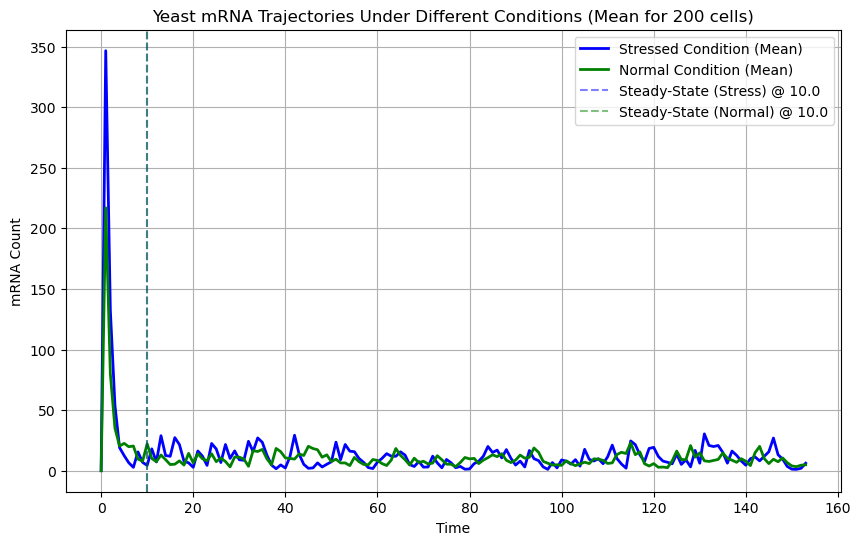

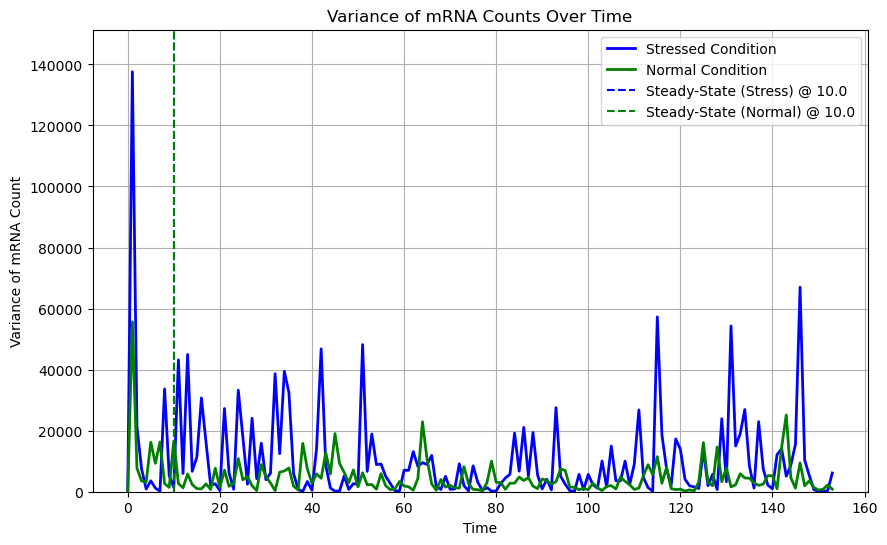


=== Variance at Steady State ===
  Stressed Condition (after 10.0 min): Mean = 10.69, Variance = 10028.48
  Normal Condition (after 10.0 min): Mean = 9.54, Variance = 4230.54


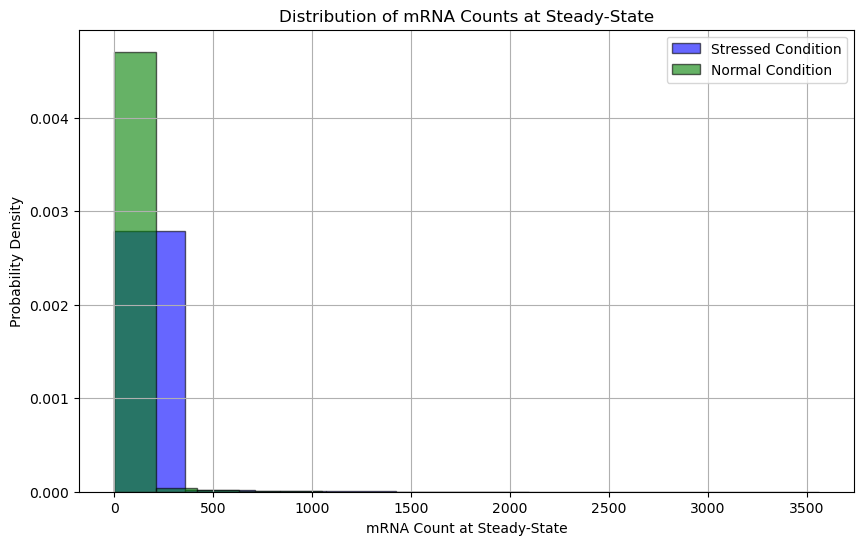

In [3]:
# Plots
plot_mRNA_trajectory(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)

SVM to classify the two different environments, ideally we'd like to make things difficult for them to distinguish

=== SVM (RBF Kernel) Classification Accuracy: 0.60 ===
=== Random Forest Accuracy: 0.68 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Accuracy: 0.53 ===
=== Random Classifier Accuracy: 0.49 ===


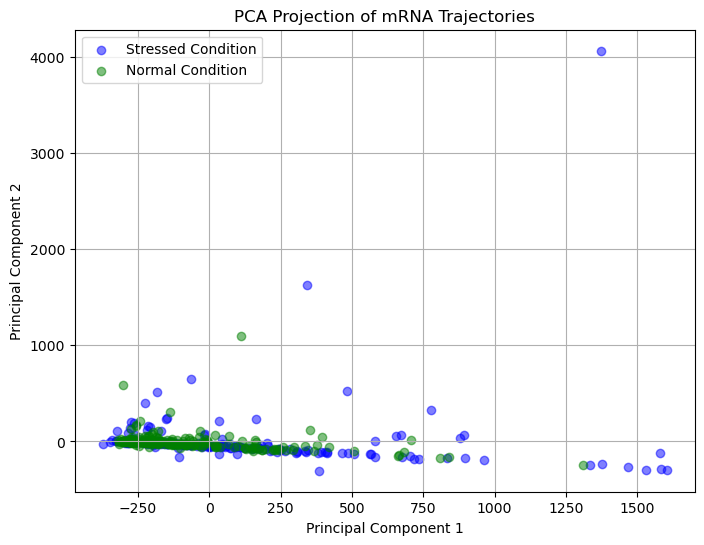

In [4]:
output_file = "data/mRNA_trajectories_mean_fixed.csv"
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

Autocorrelation

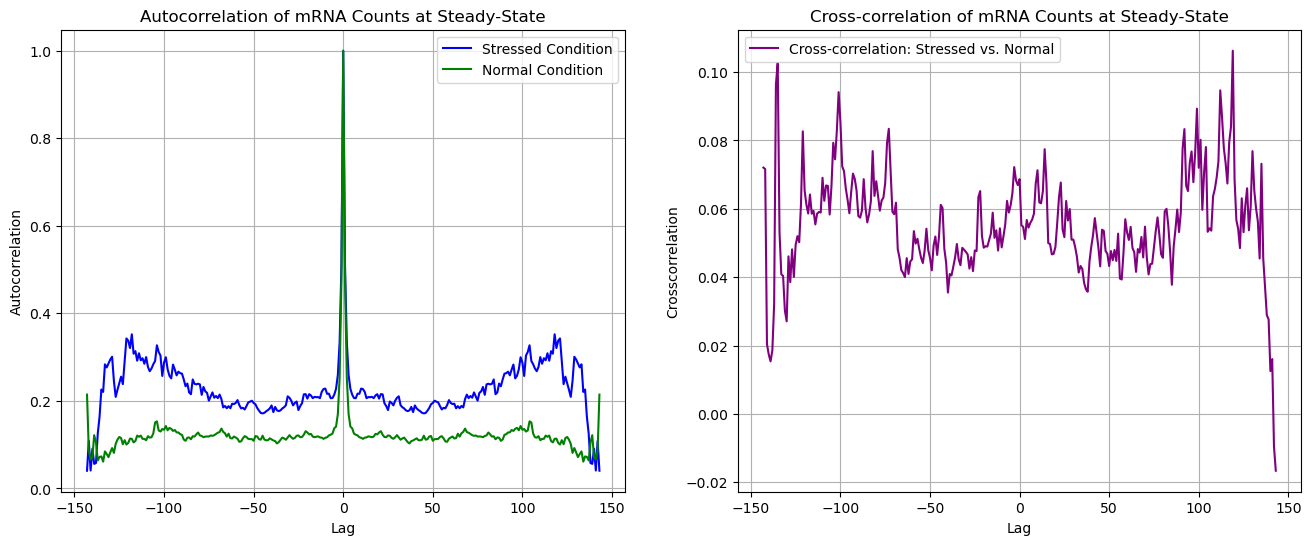

In [5]:
output_file = "data/mRNA_trajectories_mean_fixed.csv"
df_results = pd.read_csv(output_file)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

plot_autocrosscorr(parameter_sets, stress_trajectories, normal_trajectories)

## Fixing the Variance of mRNA counts
Fix the **variance** to be at a known value, using the equation 

$$ \sigma ^2 = \frac{\sigma_b \rho}{d (\sigma_b + \sigma_u)} + \frac{\sigma_u \sigma_b}{({\sigma_u + \sigma_b})^2} \frac{\rho^2}{d(\sigma_u + \sigma_b + d)} $$

Solving it for $ \rho $ using Mathematica, we get the following *positive* solution:

$$
\rho = -\frac{(\sigma_b + \sigma_u) \sqrt{ d + \sigma_b + \sigma_u} (\sqrt{\sigma_b} \sqrt{d + \sigma_b + \sigma_u} - \sqrt{\sigma_b (\sigma_b + \sigma_u) + d (\sigma_b + 4 \sigma ^2 \sigma_u)}
    )}{2 \sqrt{\sigma_b} \sigma_u}

$$

<!-- Initially, I used the sympy module from python to do the work for me, but I'm not convinced by its answers.

from sympy import symbols, Eq, solve

# Define variables
sigma_sq, sigma_b, sigma_u, rho, d = symbols('variance_target sigma_b sigma_u rho d')

# Define the given equation
eq = Eq(
    sigma_sq, 
    (sigma_b * rho) / (d * (sigma_b + sigma_u)) + 
    (sigma_u * sigma_b / (sigma_u + sigma_b)**2) * (rho**2 / (d * (sigma_u + sigma_b + d)))
)

# Solve for rho
rho_solution = solve(eq, rho)
rho_solution
 -->

### Variance of both systems to be the same

Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 18.0, 'sigma_b': 0.01, 'rho': 1841.35262672509, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems:  50%|█████     | 1/2 [00:03<00:03,  3.70s/it]

Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 9.0, 'sigma_b': 0.02, 'rho': 667.980678288759, 'd': 1.0, 'label': 1}


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:07<00:00,  3.74s/it]



=== Statistical Report ===

📊 **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 1.15
    - Variance: 122.78

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 1.45
    - Variance: 96.78
=== SVM (RBF Kernel) Classification Accuracy: 0.64 ===
=== Random Forest Accuracy: 0.66 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Accuracy: 0.60 ===
=== Random Classifier Accuracy: 0.49 ===


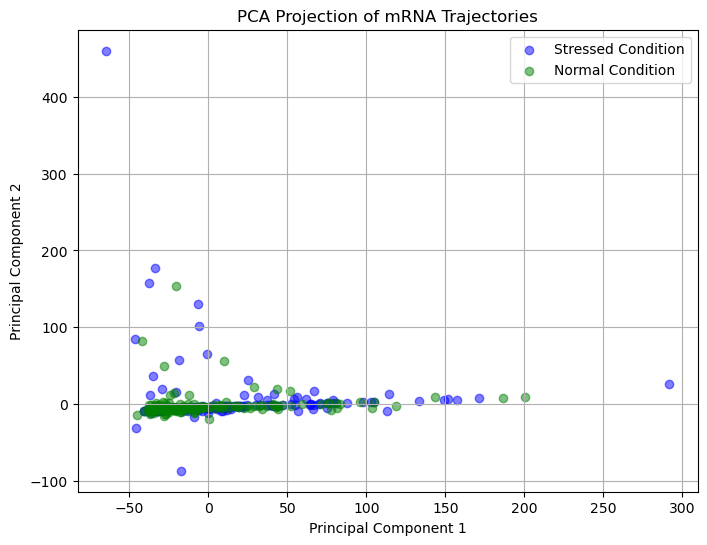

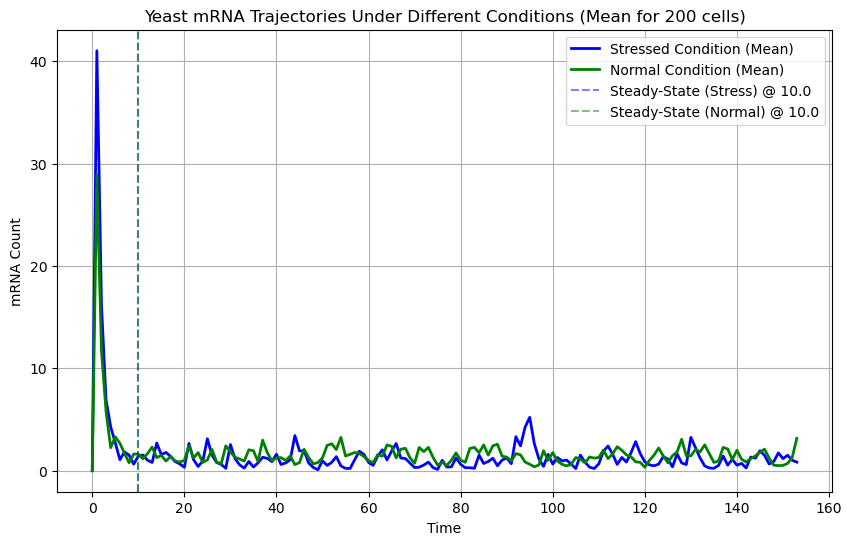

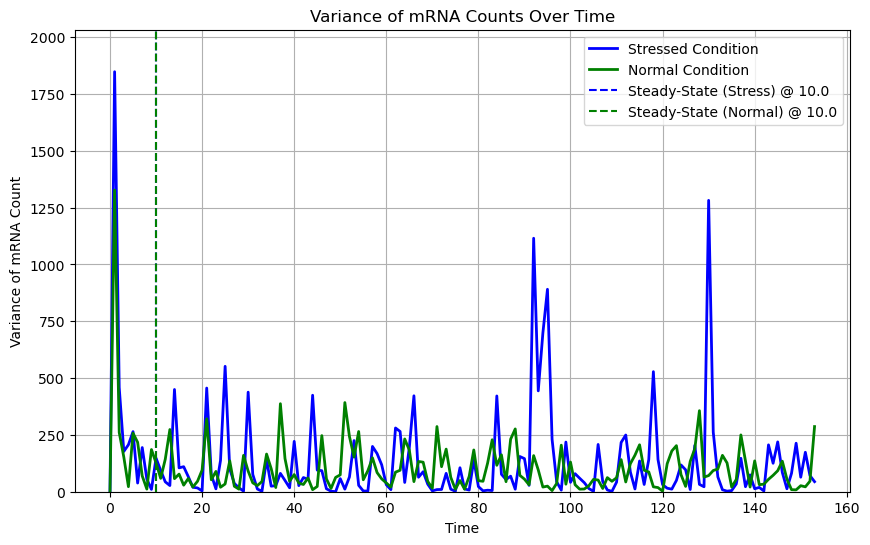


=== Variance at Steady State ===
  Stressed Condition (after 10.0 min): Mean = 1.15, Variance = 122.78
  Normal Condition (after 10.0 min): Mean = 1.45, Variance = 96.78


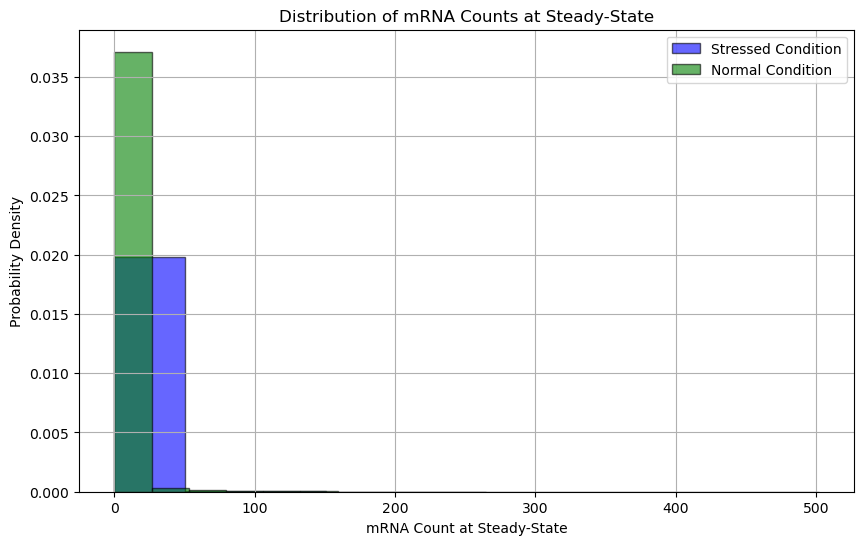

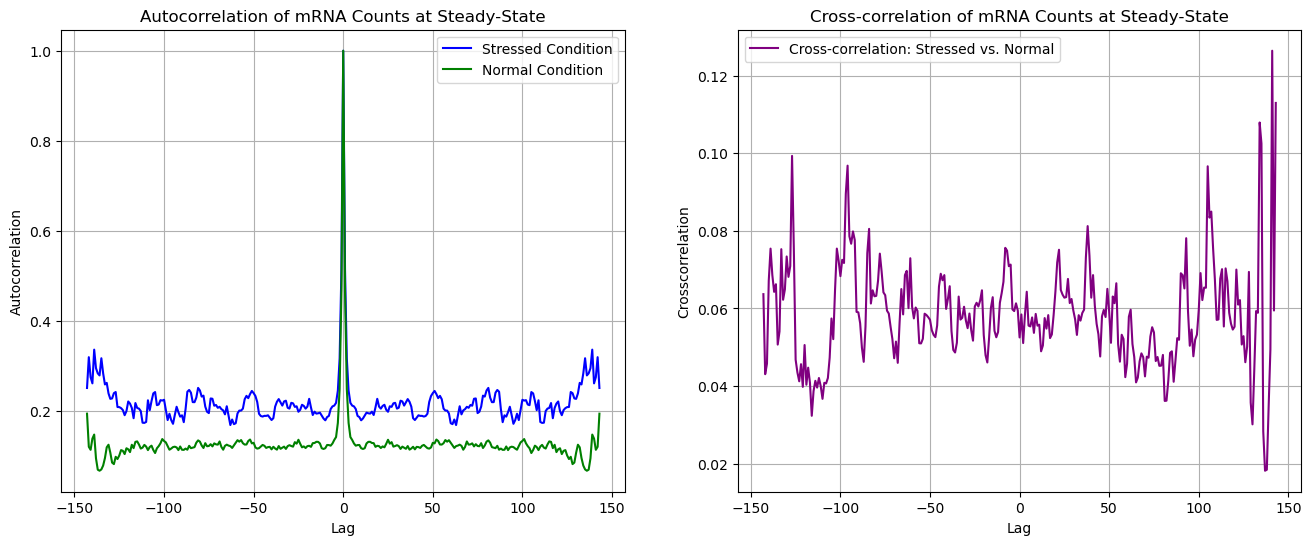

In [6]:
# Define symbols
rho, mu, sigma_sq, d, sigma_u, sigma_b = sp.symbols('rho mu sigma_sq d sigma_u sigma_b') # sigma_sq is variance
init_printing(use_unicode=True)
# define the variance and mean equations, these should be equations that are have all terms re-arranged to the LHS, and 0 on the RHS, i.e., for x = y, you are defining x - y (= 0)
variance_eq = sigma_sq - (
    sigma_b * rho / (d * (sigma_b + sigma_u)) + (sigma_u * sigma_b)*rho**2 / (d*(sigma_b + sigma_u + d)*(sigma_u + sigma_b)**2)
                          )  

# Solve the equation for rho, mu, and sigma_sq
solutions = solve(variance_eq, rho, dict= True) 

# target variance
variance_target = 100.0

# Define activation/deactivation rates and degradation rates for the conditions
parameters = {
    "stress": {"sigma_u": 18.0, "sigma_b": 0.01, "d": 1.0},
    "normal": {"sigma_u": 9.0, "sigma_b": 0.02, "d": 1.0}
}

# Store positive rho values for both conditions
rho_values = {}
for condition, param_set in parameters.items():
    for sol in solutions:
        rho_value = sol[rho].subs({
            sigma_u: param_set["sigma_u"], 
            sigma_b: param_set["sigma_b"], 
            d: param_set["d"], 
            sigma_sq: variance_target
        })
        
        # Store only positive solutions
        if rho_value > 0:
            rho_values[condition] = rho_value
            break  # Stop searching if positive solution is found

# Updated Parameter Sets using the calculated rho values
parameter_sets = [
    {"sigma_u": parameters["stress"]["sigma_u"], 
     "sigma_b": parameters["stress"]["sigma_b"], 
     "rho": rho_values["stress"], 
     "d": parameters["stress"]["d"], 
     "label": 0},
     
    {"sigma_u": parameters["normal"]["sigma_u"], 
     "sigma_b": parameters["normal"]["sigma_b"], 
     "rho": rho_values["normal"], 
     "d": parameters["normal"]["d"], 
     "label": 1}
]

# Set up simulation parameters 
# get the min degradation rate
min_d = min([param_set['d'] for param_set in parameter_sets])    
# get the time point after which the system reaches steady state 
steady_state_time = int(10 / min_d)

# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points
# extend time points to account for steady state
extended_time_points = np.arange(time_points[0], 
                                 len(time_points) + steady_state_time, 
                                 time_points[1] - time_points[0])

size = 200  # size of the simulation needs to be big enough for this particular system to reach steady state

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, extended_time_points, size)

# Save dataset for ML classification
output_file = f"data/mRNA_trajectories_variance_fixed_{variance_target}_{variance_target}.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report =  statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

# Plots
plot_mRNA_trajectory(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)
plot_autocrosscorr(parameter_sets, stress_trajectories, normal_trajectories)

Changing the variance ratio

Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 18.0, 'sigma_b': 0.01, 'rho': 2018.00398888118, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems:  50%|█████     | 1/2 [00:03<00:03,  3.73s/it]

Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 9.0, 'sigma_b': 0.02, 'rho': 667.980678288759, 'd': 1.0, 'label': 1}


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:07<00:00,  3.77s/it]



=== Statistical Report ===

📊 **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 1.12
    - Variance: 125.44

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 1.50
    - Variance: 99.66
=== SVM (RBF Kernel) Classification Accuracy: 0.56 ===
=== Random Forest Accuracy: 0.65 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Accuracy: 0.56 ===
=== Random Classifier Accuracy: 0.54 ===


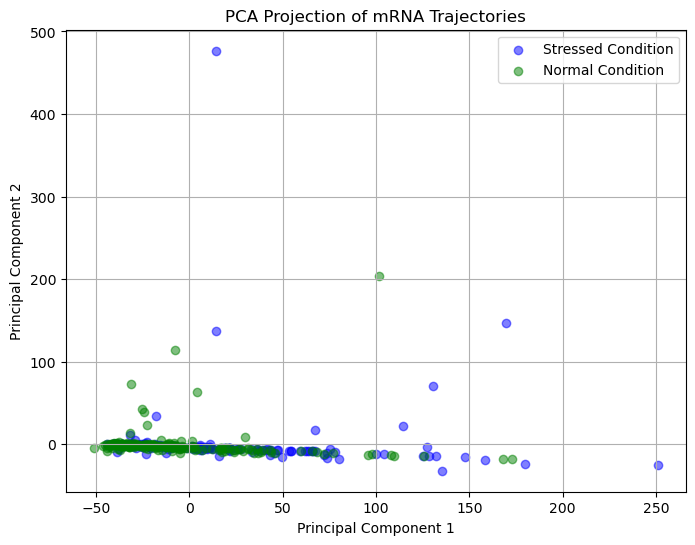

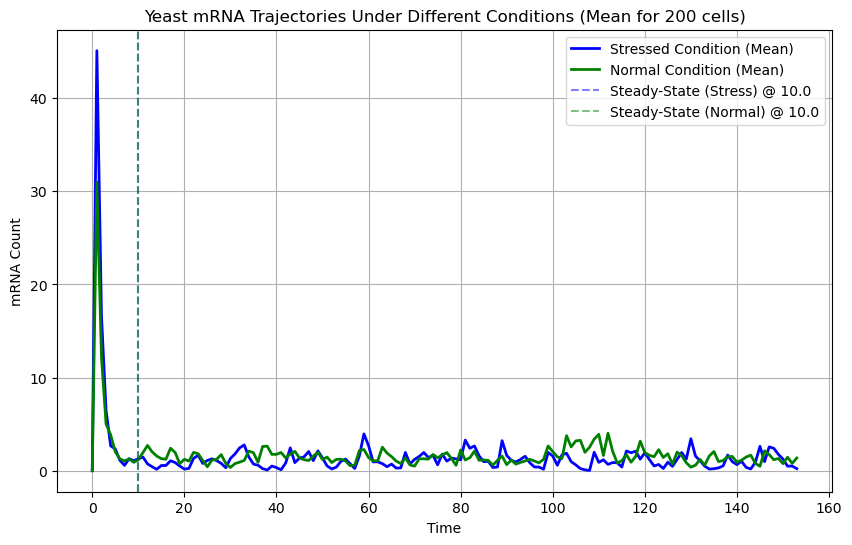

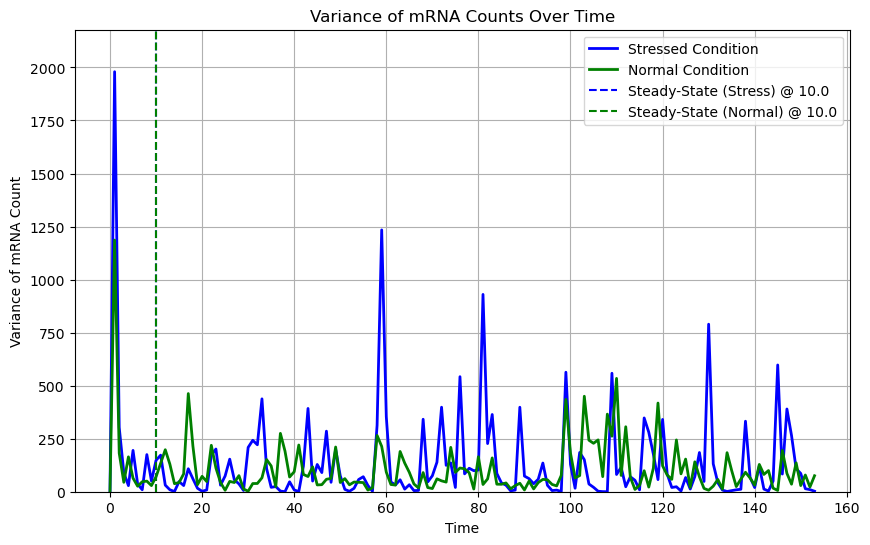


=== Variance at Steady State ===
  Stressed Condition (after 10.0 min): Mean = 1.12, Variance = 125.44
  Normal Condition (after 10.0 min): Mean = 1.50, Variance = 99.66


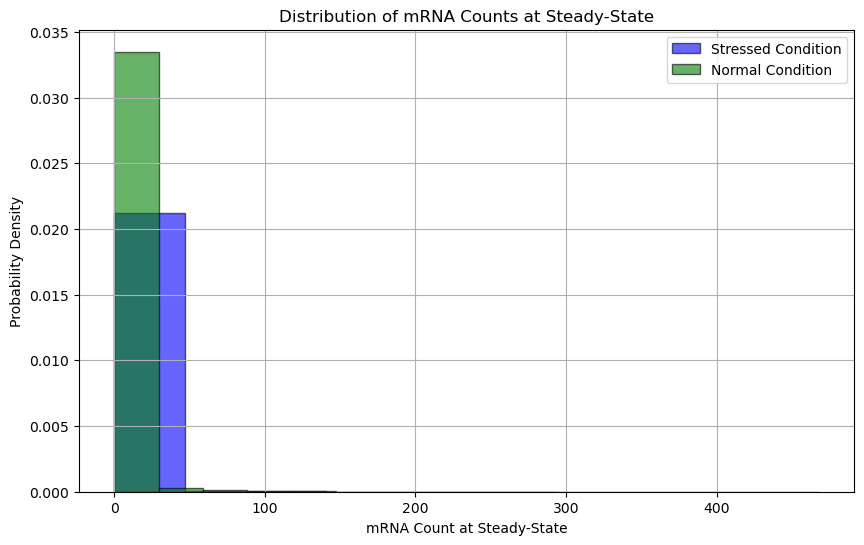

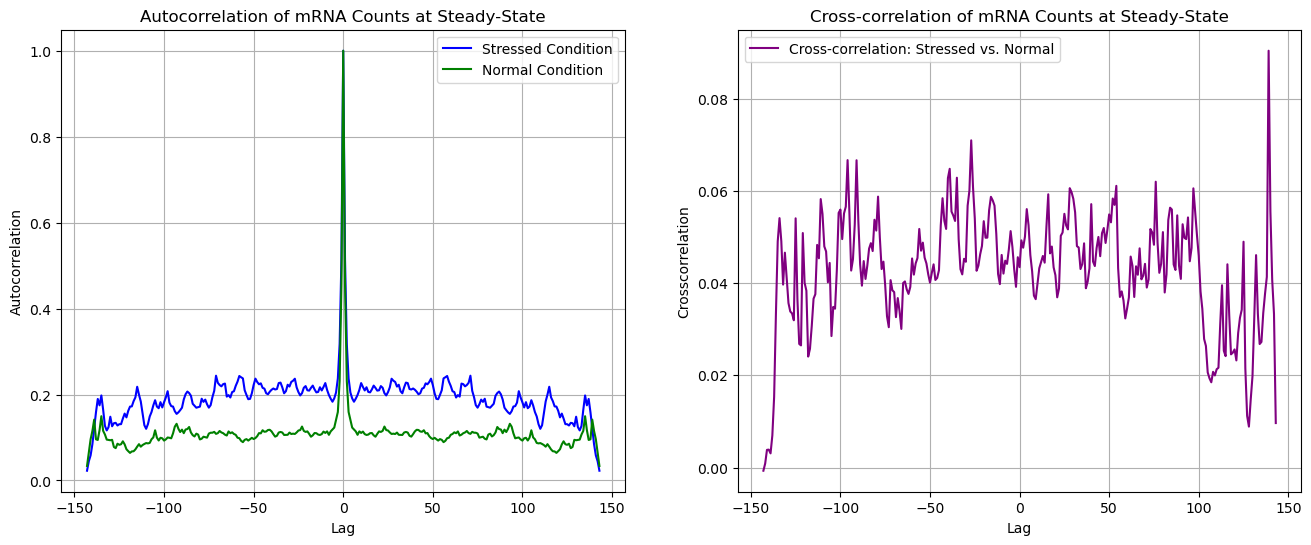

In [3]:
# Define symbols
rho, mu, sigma_sq, d, sigma_u, sigma_b = sp.symbols('rho mu sigma_sq d sigma_u sigma_b') # sigma_sq is variance
init_printing(use_unicode=True)
# define the variance and mean equations, these should be equations that are have all terms re-arranged to the LHS, and 0 on the RHS, i.e., for x = y, you are defining x - y (= 0)
variance_eq = sigma_sq - (
    sigma_b * rho / (d * (sigma_b + sigma_u)) + (sigma_u * sigma_b)*rho**2 / (d*(sigma_b + sigma_u + d)*(sigma_u + sigma_b)**2)
                          )  

# Solve the equation for rho, mu, and sigma_sq
solutions = solve(variance_eq, rho, dict= True) 

# target variance
variance_target_normal = 100.0
variance_target_stress = 120.0

# Define activation/deactivation rates and degradation rates for the conditions
parameters = {
    "stress": {"sigma_u": 18.0, "sigma_b": 0.01, "d": 1.0},
    "normal": {"sigma_u": 9.0, "sigma_b": 0.02, "d": 1.0}
}

# Store positive rho values for both conditions
rho_values = {}
for condition, param_set in parameters.items():
    for sol in solutions:

        if condition == "stress":
            variance_target = variance_target_stress
        else:
            variance_target = variance_target_normal

        rho_value = sol[rho].subs({
            sigma_u: param_set["sigma_u"], 
            sigma_b: param_set["sigma_b"], 
            d: param_set["d"], 
            sigma_sq: variance_target
        })
        
        # Store only positive solutions
        if rho_value > 0:
            rho_values[condition] = rho_value
            break  # Stop searching if positive solution is found

# Updated Parameter Sets using the calculated rho values
parameter_sets = [
    {"sigma_u": parameters["stress"]["sigma_u"], 
     "sigma_b": parameters["stress"]["sigma_b"], 
     "rho": rho_values["stress"], 
     "d": parameters["stress"]["d"], 
     "label": 0},
     
    {"sigma_u": parameters["normal"]["sigma_u"], 
     "sigma_b": parameters["normal"]["sigma_b"], 
     "rho": rho_values["normal"], 
     "d": parameters["normal"]["d"], 
     "label": 1}
]

# Set up simulation parameters 
# get the min degradation rate
min_d = min([param_set['d'] for param_set in parameter_sets])    
# get the time point after which the system reaches steady state 
steady_state_time = int(10 / min_d)

# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points
# extend time points to account for steady state
extended_time_points = np.arange(time_points[0], 
                                 len(time_points) + steady_state_time, 
                                 time_points[1] - time_points[0])

size = 200  # size of the simulation needs to be big enough for this particular system to reach steady state

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, extended_time_points, size)

# Save dataset for ML classification
output_file = f"data/mRNA_trajectories_variance_fixed_{variance_target}_{variance_target}.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report =  statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

# Plots
plot_mRNA_trajectory(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)
plot_autocrosscorr(parameter_sets, stress_trajectories, normal_trajectories)

## Fix the mean AND variance
This will involve solving 2 simutaneous equations, changing 2 parameters

[190.   1.]
[-3.1441516057384433e-13, -3.424815986363683e-12]
[108.24471805   0.91607978]
[-2.5579538487363607e-13, 5.016431714466307e-12]
Calculated rho values: {'stress': 189.9999999999988, 'normal': 108.24471804790372}
Updated Parameter Sets: [{'sigma_u': 18.0, 'sigma_b': 0.9999999999999734, 'rho': 189.9999999999988, 'd': 1.0, 'label': 0}, {'sigma_u': 9.0, 'sigma_b': 0.9160797830995233, 'rho': 108.24471804790372, 'd': 1.0, 'label': 1}]


Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 18.0, 'sigma_b': 0.9999999999999734, 'rho': 189.9999999999988, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems:  50%|█████     | 1/2 [00:13<00:13, 13.18s/it]

Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 9.0, 'sigma_b': 0.9160797830995233, 'rho': 108.24471804790372, 'd': 1.0, 'label': 1}


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:25<00:00, 12.73s/it]



=== Statistical Report ===

📊 **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 10.04
    - Variance: 100.09

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 9.89
    - Variance: 97.55
=== SVM (RBF Kernel) Classification Accuracy: 0.60 ===
=== Random Forest Accuracy: 0.46 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Accuracy: 0.51 ===
=== Random Classifier Accuracy: 0.57 ===


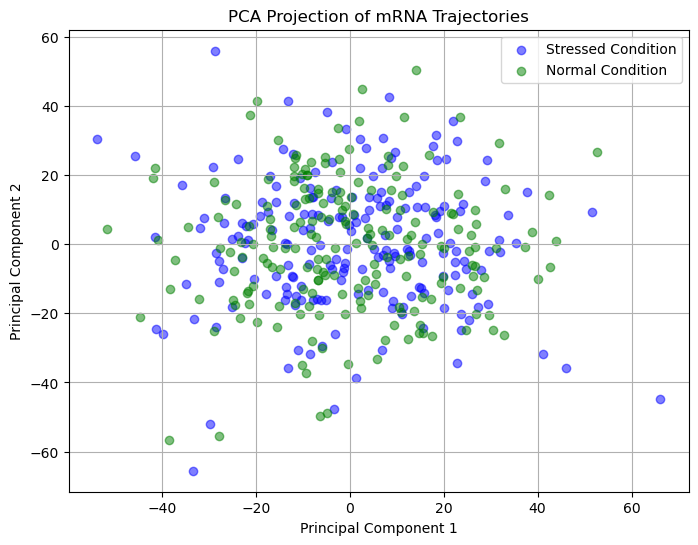

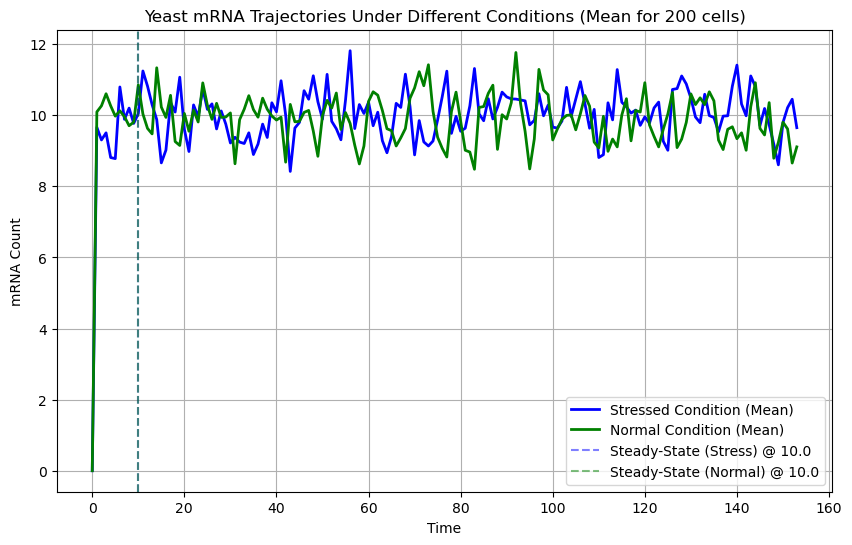

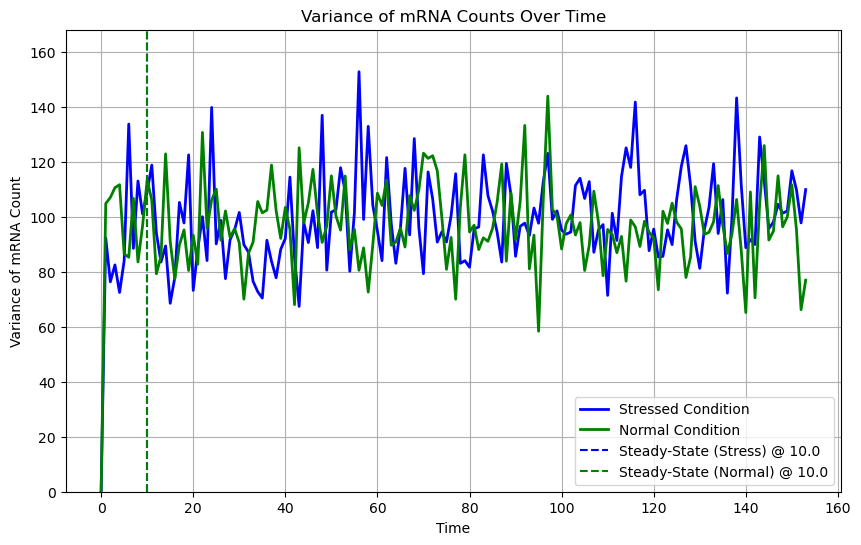


=== Variance at Steady State ===
  Stressed Condition (after 10.0 min): Mean = 10.04, Variance = 100.09
  Normal Condition (after 10.0 min): Mean = 9.89, Variance = 97.55


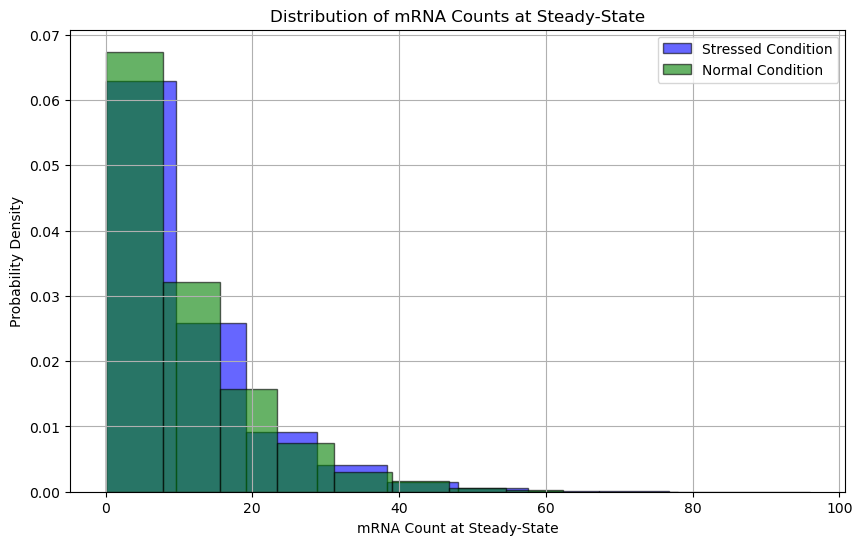

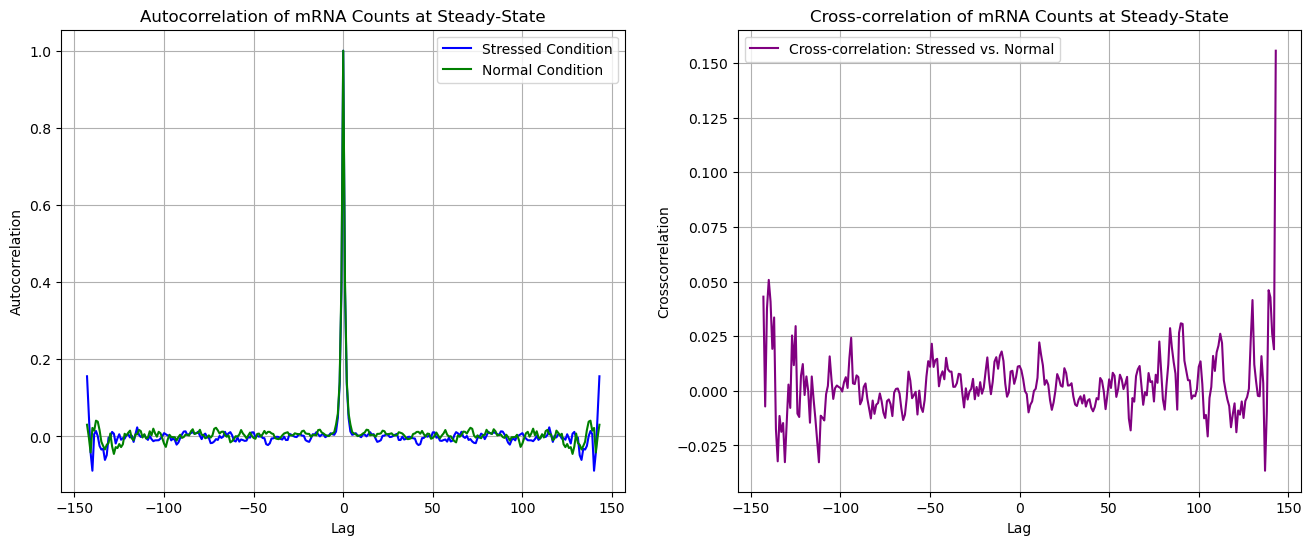

In [54]:
# Importing necessary modules
import sympy as sp
from sympy import init_printing
from scipy.optimize import fsolve
import numpy as np

# Define symbols
rho, mu, sigma_sq, d, sigma_u, sigma_b = sp.symbols('rho mu sigma_sq d sigma_u sigma_b')  # sigma_sq is variance
init_printing(use_unicode=True)

# Define the variance and mean equations

def equations(vars, sigma_u, sigma_b, d, mu_target, variance_target):
    rho = vars[0]
    sigma_b = vars[1]

    # Mean equation
    mean_eqn = sigma_b * rho / (d * (sigma_b + sigma_u))

    # Variance equation
    variance_eqn = (sigma_b * rho / (d * (sigma_b + sigma_u))) + \
                     ((sigma_u * sigma_b) * rho**2 / (d * (sigma_b + sigma_u + d) * (sigma_u + sigma_b)**2))

    # Define the equations to be solved
    eq1 = mean_eqn - mu_target
    eq2 = variance_eqn - variance_target

    return [eq1, eq2]


# Target variance and mean
variance_target = 100.0
mu_target = 10.0

# Define activation/deactivation rates and degradation rates for the conditions
parameters = {
    "stress": {"sigma_u": 18.0, "sigma_b": 0.01, "d": 1.0},
    "normal": {"sigma_u": 9.0, "sigma_b": 0.02, "d": 1.0}
}

# Store positive rho values for both conditions
rho_values = {}
sigma_b_values = {}

for condition, param_set in parameters.items():
    # Initial guess for rho
    initial_guess = [100, 1]

    # Solve using fsolve
    solution = fsolve(equations, initial_guess, args=(param_set['sigma_u'], param_set['sigma_b'], param_set['d'], mu_target, variance_target))
    print(solution)
     
    # checking the solved equations
    solved_equations = equations(solution, param_set['sigma_u'], param_set['sigma_b'], param_set['d'], mu_target, variance_target)
    print(solved_equations)

    # Check if the solution is positive
    if solution[0] > 0:
        # print(equations)
        rho_values[condition] = solution[0]
        sigma_b_values[condition] = solution[1]


# Updated Parameter Sets using the calculated rho values
parameter_sets = [
    {"sigma_u": parameters["stress"]["sigma_u"],
     "sigma_b": sigma_b_values["stress"],
     "rho": rho_values["stress"],
     "d": parameters["stress"]["d"],
     "label": 0},

    {"sigma_u": parameters["normal"]["sigma_u"],
     "sigma_b": sigma_b_values["normal"],
     "rho": rho_values["normal"],
     "d": parameters["normal"]["d"],
     "label": 1}
]

# Output the results
print("Calculated rho values:", rho_values)
print("Updated Parameter Sets:", parameter_sets)

# Set up simulation parameters 
# get the min degradation rate
min_d = min([param_set['d'] for param_set in parameter_sets])    
# get the time point after which the system reaches steady state 
steady_state_time = int(10 / min_d)

# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points
# extend time points to account for steady state
extended_time_points = np.arange(time_points[0], 
                                 len(time_points) + steady_state_time, 
                                 time_points[1] - time_points[0])

size = 200  # size of the simulation needs to be big enough for this particular system to reach steady state

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, extended_time_points, size)

# Save dataset for ML classification
output_file = f"data/mRNA_trajectories_var_mean_fixed_{variance_target}_{mu_target}.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report =  statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

# Plots
plot_mRNA_trajectory(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)
plot_autocrosscorr(parameter_sets, stress_trajectories, normal_trajectories)

In [41]:
import sympy as sp
from scipy.optimize import fsolve

# Target values
variance_target = 100.0
mu_target = 20.0

parameters = {
    "stress": {"sigma_u": 10.0, "sigma_b": 4.0, "d": 1.0},
    "normal": {"sigma_u": 5.0, "sigma_b": 8.0, "d": 1.0}
}

rho_values = {}

for condition, params in parameters.items():
    sigma_u_val = params["sigma_u"]
    sigma_b_val = params["sigma_b"]
    d_val = params["d"]
    
    # Define equations to solve
    def equations(rho):
        mean = sigma_b_val * rho / (d_val * (sigma_b_val + sigma_u_val))
        variance_term = (sigma_u_val * sigma_b_val * rho**2) / (d_val * (sigma_b_val + sigma_u_val + d_val) * (sigma_b_val + sigma_u_val)**2)
        return [mean - mu_target, (mean + variance_term) - variance_target]
    
    # Use fsolve to find rho
    rho_guess = mu_target * d_val * (sigma_b_val + sigma_u_val) / sigma_b_val  # Initial guess from mean equation
    rho_solution = fsolve(equations, rho_guess)
    
    if rho_solution > 0:
        rho_values[condition] = rho_solution

print(rho_values)

ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.

Calculated rho values: {'stress': 75.87273875477146, 'normal': 60.83315759856745}
Updated Parameter Sets: [{'sigma_u': 10.0, 'sigma_b': 4.0, 'rho': 75.87273875477146, 'd': 1.0, 'label': 0}, {'sigma_u': 5.0, 'sigma_b': 8.0, 'rho': 60.83315759856745, 'd': 1.0, 'label': 1}]


Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 10.0, 'sigma_b': 4.0, 'rho': 75.87273875477146, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems:  50%|█████     | 1/2 [00:26<00:26, 26.07s/it]

Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 5.0, 'sigma_b': 8.0, 'rho': 60.83315759856745, 'd': 1.0, 'label': 1}


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [01:11<00:00, 35.75s/it]



=== Statistical Report ===

📊 **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 21.63
    - Variance: 98.81

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 37.51
    - Variance: 100.72
=== SVM (RBF Kernel) Classification Accuracy: 1.00 ===
=== Random Forest Accuracy: 1.00 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Accuracy: 0.55 ===
=== Random Classifier Accuracy: 0.44 ===


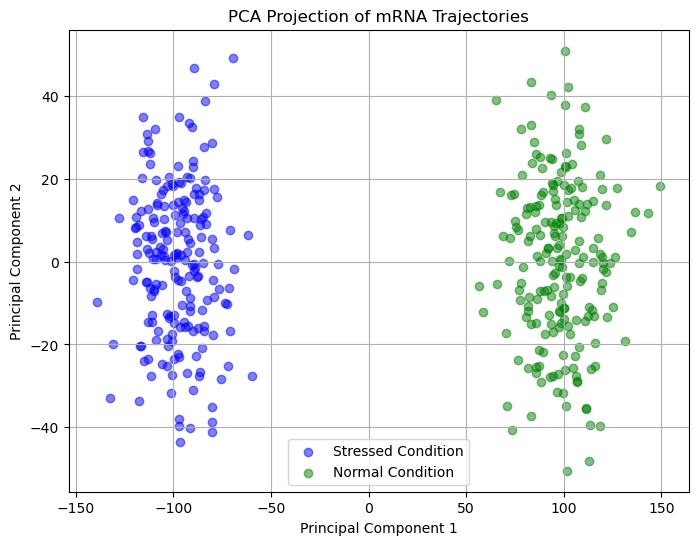

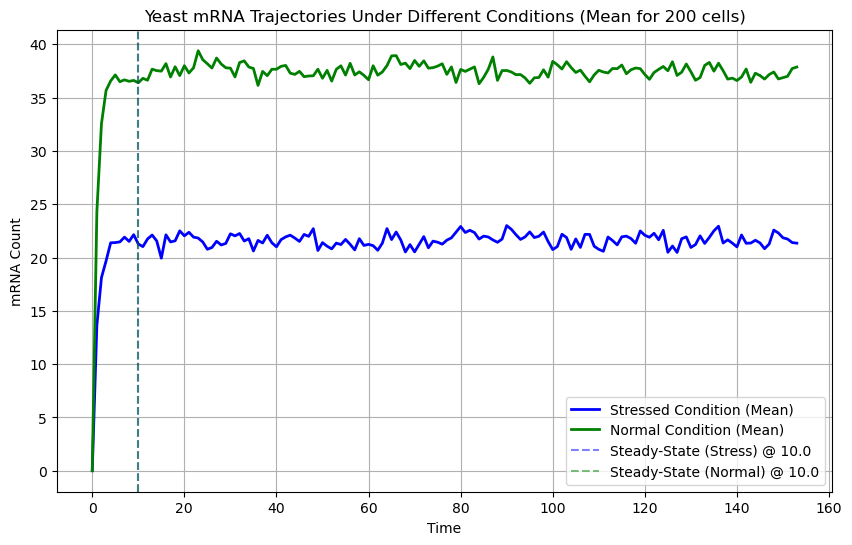

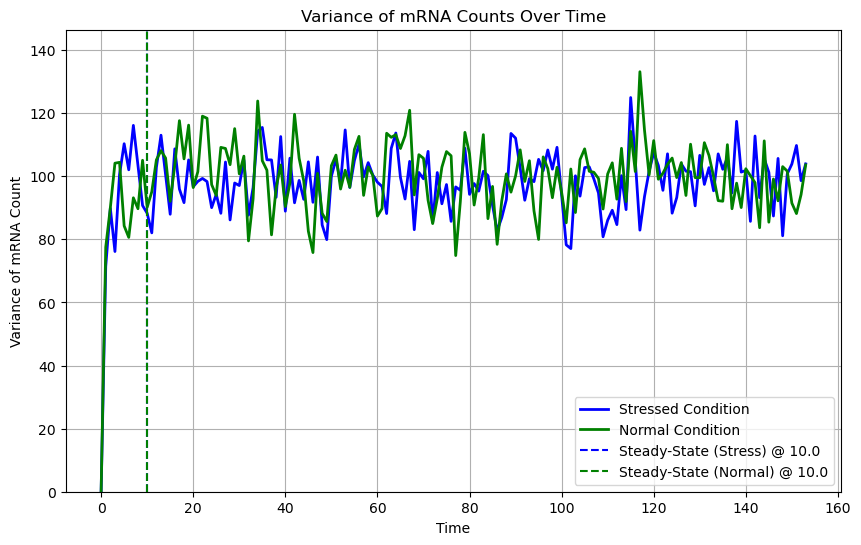


=== Variance at Steady State ===
  Stressed Condition (after 10.0 min): Mean = 21.63, Variance = 98.81
  Normal Condition (after 10.0 min): Mean = 37.51, Variance = 100.72


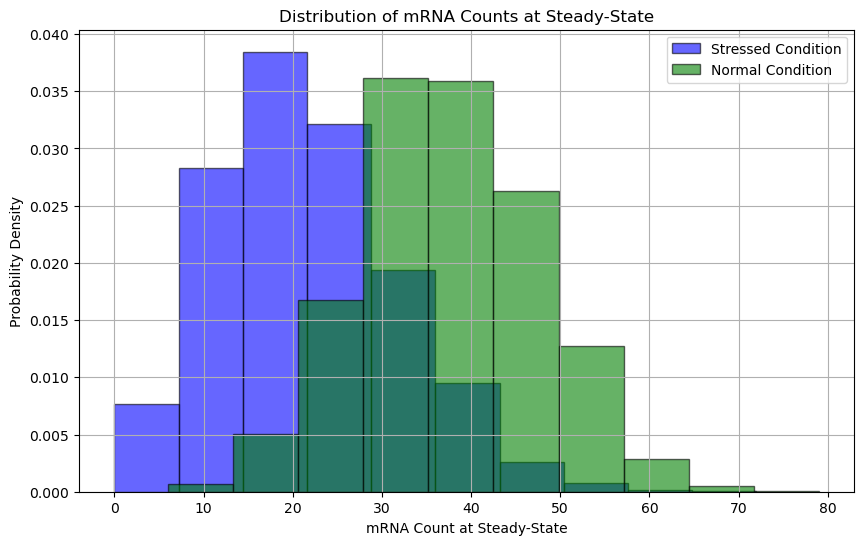

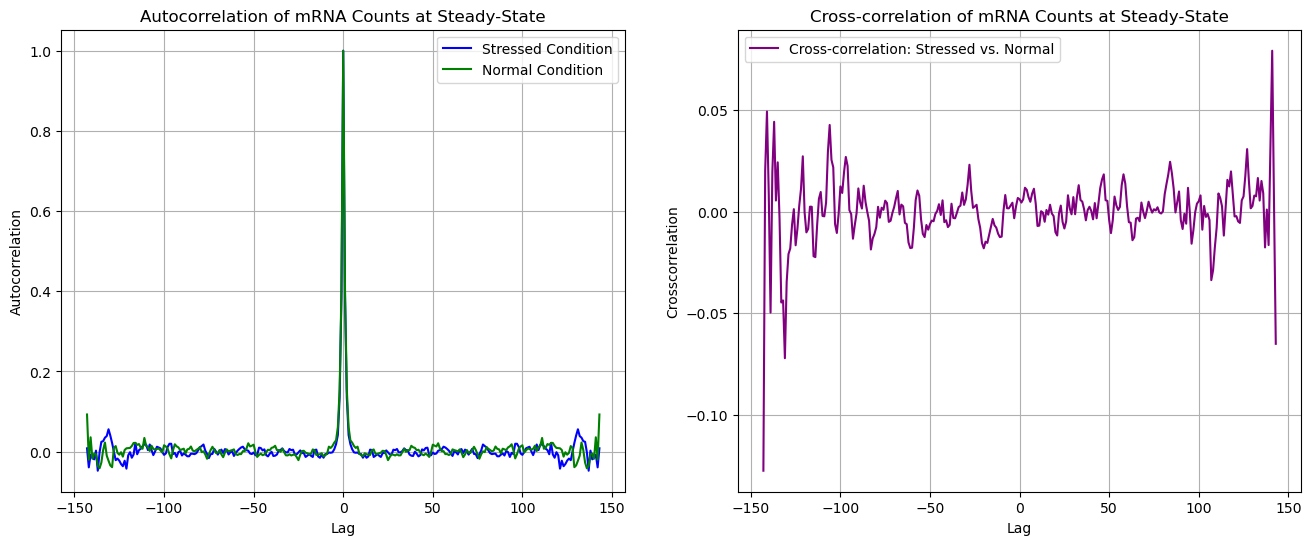

In [37]:
# Importing necessary modules
import sympy as sp
from sympy import init_printing
from scipy.optimize import fsolve
import numpy as np

# Define symbols
rho, mu, sigma_sq, d, sigma_u, sigma_b = sp.symbols('rho mu sigma_sq d sigma_u sigma_b')  # sigma_sq is variance
init_printing(use_unicode=True)

# Define the mean equation
def mean_equation(rho, sigma_u, sigma_b, d, mu_target):
    mean_value = sigma_b * rho / (d * (sigma_b + sigma_u))
    return mean_value - mu_target

# Define the variance equation

def variance_equation(rho, sigma_u, sigma_b, d, variance_target):
    variance_value = (sigma_b * rho / (d * (sigma_b + sigma_u))) + \
                     ((sigma_u * sigma_b) * rho**2 / (d * (sigma_b + sigma_u + d) * (sigma_u + sigma_b)**2))
    return variance_value - variance_target

# Target variance and mean
variance_target = 100.0
mu_target = 15.0

# Define activation/deactivation rates and degradation rates for the conditions
parameters = {
    "stress": {"sigma_u": 10.0, "sigma_b": 4.0, "d": 1.0},
    "normal": {"sigma_u": 5.0, "sigma_b": 8.0, "d": 1.0}
}

# Store positive rho values for both conditions
rho_values = {}

for condition, param_set in parameters.items():
    # Step 1: Find rho that satisfies the mean equation
    rho_mean = fsolve(mean_equation, [100], args=(param_set['sigma_u'], param_set['sigma_b'], param_set['d'], mu_target))[0]

    # Step 2: Use the rho from Step 1 to solve the variance equation
    rho_var = fsolve(variance_equation, [rho_mean], args=(param_set['sigma_u'], param_set['sigma_b'], param_set['d'], variance_target))[0]

    # Check if the solution is positive
    if rho_var > 0:
        rho_values[condition] = rho_var

# Updated Parameter Sets using the calculated rho values
parameter_sets = [
    {"sigma_u": parameters["stress"]["sigma_u"],
     "sigma_b": parameters["stress"]["sigma_b"],
     "rho": rho_values["stress"],
     "d": parameters["stress"]["d"],
     "label": 0},

    {"sigma_u": parameters["normal"]["sigma_u"],
     "sigma_b": parameters["normal"]["sigma_b"],
     "rho": rho_values["normal"],
     "d": parameters["normal"]["d"],
     "label": 1}
]

# Output the results
print("Calculated rho values:", rho_values)
print("Updated Parameter Sets:", parameter_sets)
# Set up simulation parameters 
# get the min degradation rate
min_d = min([param_set['d'] for param_set in parameter_sets])    
# get the time point after which the system reaches steady state 
steady_state_time = int(10 / min_d)

# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points
# extend time points to account for steady state
extended_time_points = np.arange(time_points[0], 
                                 len(time_points) + steady_state_time, 
                                 time_points[1] - time_points[0])

size = 200  # size of the simulation needs to be big enough for this particular system to reach steady state

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, extended_time_points, size)

# Save dataset for ML classification
output_file = f"data/mRNA_trajectories_var_mean_fixed_{variance_target}_{mu_target}.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report =  statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

# Plots
plot_mRNA_trajectory(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)
plot_autocrosscorr(parameter_sets, stress_trajectories, normal_trajectories)

Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 18.0, 'sigma_b': 0.01, 'rho': 1755.85954748664, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems:  50%|█████     | 1/2 [00:03<00:03,  3.07s/it]

Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 9.0, 'sigma_b': 0.02, 'rho': 638.447808360245, 'd': 1.0, 'label': 1}


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:06<00:00,  3.34s/it]



=== Statistical Report ===

📊 **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 0.94
    - Variance: 91.42

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 1.33
    - Variance: 80.50
=== SVM (RBF Kernel) Classification Accuracy: 0.54 ===
=== Random Forest Accuracy: 0.65 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Accuracy: 0.70 ===
=== Random Classifier Accuracy: 0.39 ===


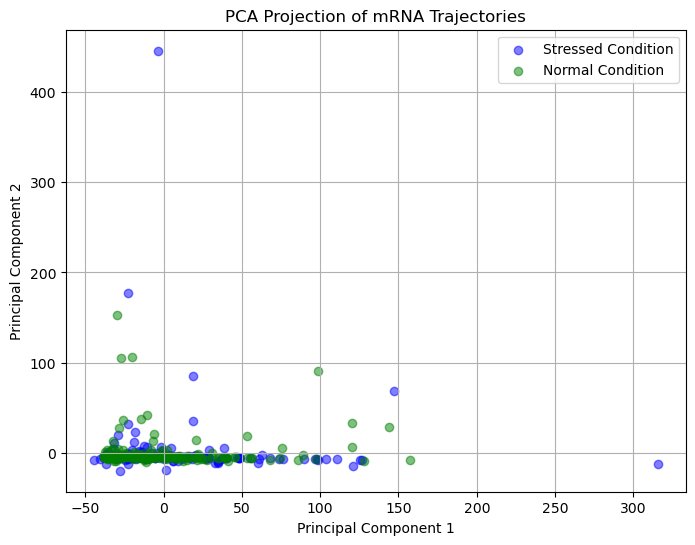

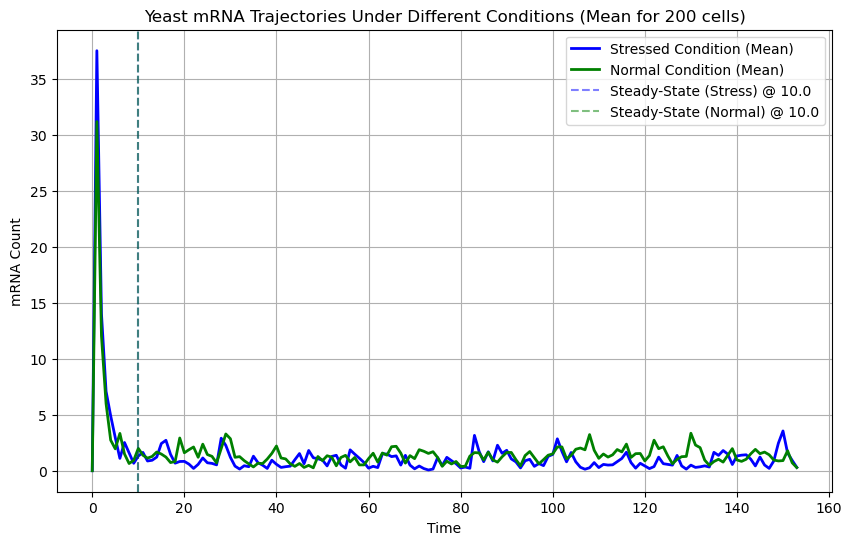

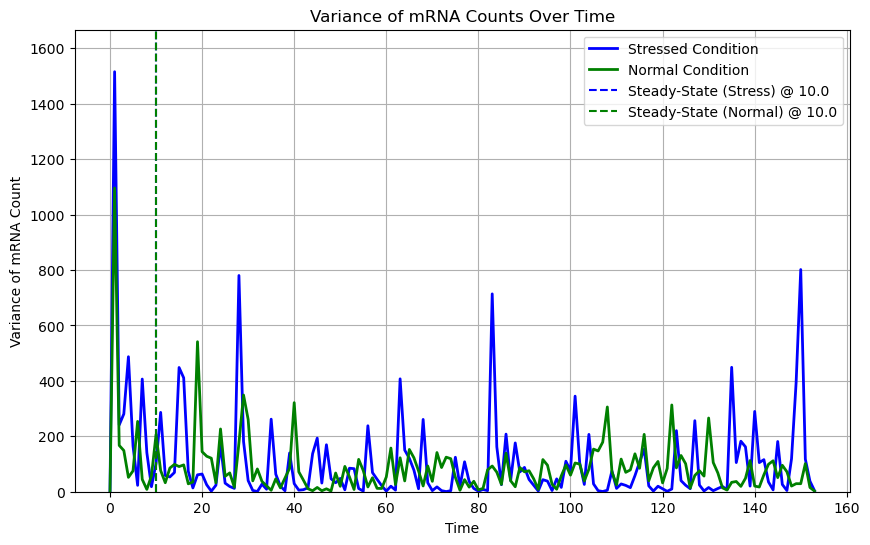


=== Variance at Steady State ===
  Stressed Condition (after 10.0 min): Mean = 0.94, Variance = 91.42
  Normal Condition (after 10.0 min): Mean = 1.33, Variance = 80.50


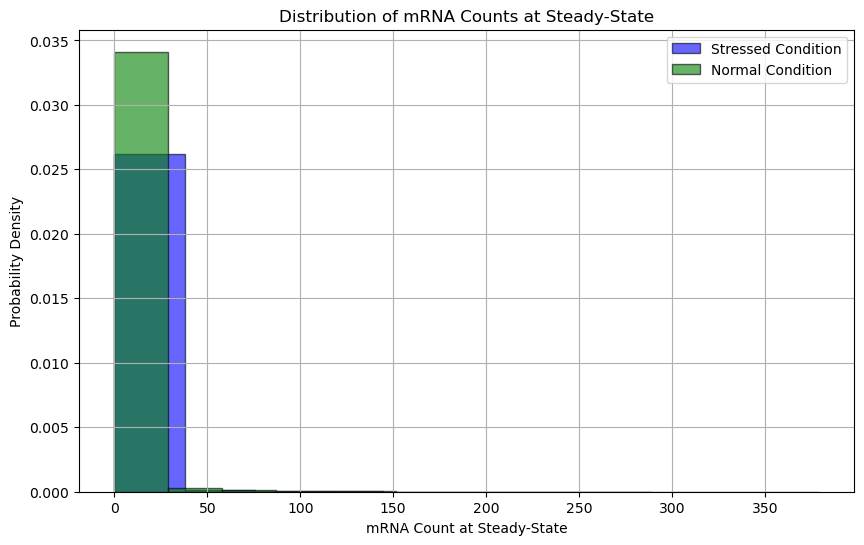

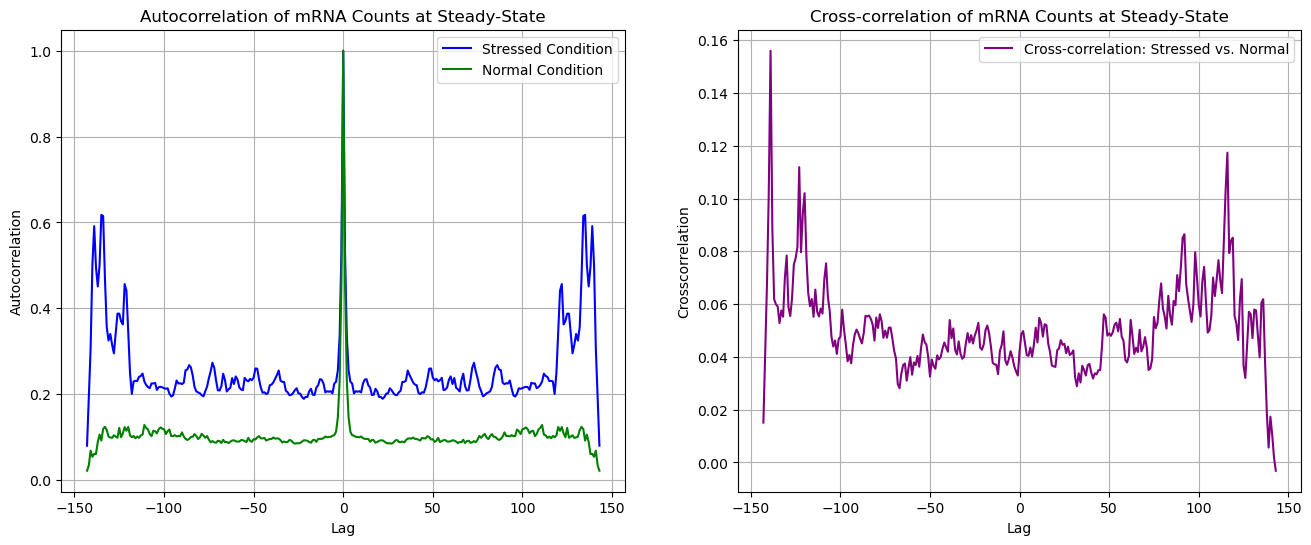

In [7]:
# Define symbols
rho, mu, sigma_sq, d, sigma_u, sigma_b = sp.symbols('rho mu sigma_sq d sigma_u sigma_b') # sigma_sq is variance
init_printing(use_unicode=True)
# define the variance and mean equations, these should be equations that are have all terms re-arranged to the LHS, and 0 on the RHS, i.e., for x = y, you are defining x - y (= 0)
mean_eq = mu - (
    sigma_b * rho / (d * (sigma_b + sigma_u))
                )

variance_eq = sigma_sq - (
    sigma_b * rho / (d * (sigma_b + sigma_u)) + (sigma_u * sigma_b)*rho**2 / (d*(sigma_b + sigma_u + d)*(sigma_u + sigma_b)**2)
                          )  

# Solve the equation for rho
solutions = solve([variance_eq - mean_eq], rho, dict = True) 

# target variance
variance_target = 100.0
# target mean
mu_target = 10.0  

# Define activation/deactivation rates and degradation rates for the conditions
parameters = {
    "stress": {"sigma_u": 18.0, "sigma_b": 0.01, "d": 1.0},
    "normal": {"sigma_u": 9.0, "sigma_b": 0.02, "d": 1.0}
}

# Store positive rho values for both conditions
rho_values = {}
for condition, param_set in parameters.items():
    for sol in solutions:
        rho_value = sol[rho].subs({
            sigma_u: param_set["sigma_u"], 
            sigma_b: param_set["sigma_b"], 
            d: param_set["d"], 
            mu: mu_target, 
            sigma_sq: variance_target
        })
        
        # Store only positive solutions
        if rho_value > 0:
            rho_values[condition] = rho_value
            break  # Stop searching if positive solution is found

# Updated Parameter Sets using the calculated rho values
parameter_sets = [
    {"sigma_u": parameters["stress"]["sigma_u"], 
     "sigma_b": parameters["stress"]["sigma_b"], 
     "rho": rho_values["stress"], 
     "d": parameters["stress"]["d"], 
     "label": 0},
     
    {"sigma_u": parameters["normal"]["sigma_u"], 
     "sigma_b": parameters["normal"]["sigma_b"], 
     "rho": rho_values["normal"], 
     "d": parameters["normal"]["d"], 
     "label": 1}
]

# Set up simulation parameters 
# get the min degradation rate
min_d = min([param_set['d'] for param_set in parameter_sets])    
# get the time point after which the system reaches steady state 
steady_state_time = int(10 / min_d)

# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points
# extend time points to account for steady state
extended_time_points = np.arange(time_points[0], 
                                 len(time_points) + steady_state_time, 
                                 time_points[1] - time_points[0])

size = 200  # size of the simulation needs to be big enough for this particular system to reach steady state

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, extended_time_points, size)

# Save dataset for ML classification
output_file = f"data/mRNA_trajectories_var_mean_fixed_{variance_target}_{mu_target}.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report =  statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

# Plots
plot_mRNA_trajectory(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)
plot_autocrosscorr(parameter_sets, stress_trajectories, normal_trajectories)

Setting the autocorrelation 